###  Imports

In [1]:
item_list = ['flag', 'person', 'helmet', 'basket ball', 'baseball glove', 'space shuttle', 'camera', 'train', 'UH-1 Huey', 'T-72 tank', 'football helmet', 'soccer ball', 'baseball bat', 'tennis racket', 'cleats shoes', 'boxing gloves', 'man reading a newspaper', 'bike', 'newspaper', 'baby sitting in a swing', 'football', 'tree', 'green grass', 'blue sky', 'road', 'sea turtle', 'fish', 'kanye west', 'little girl', 'airplane', 'SR-71', 'car', 'satellite photo of a car', 'parking lot', 'crosswalk']


image_dir = r'./test_images'

loaded checkpoint at epoch 9


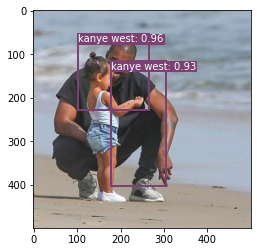

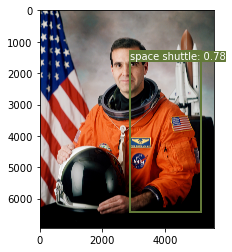

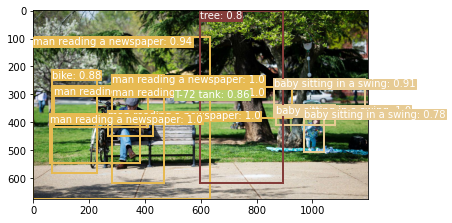

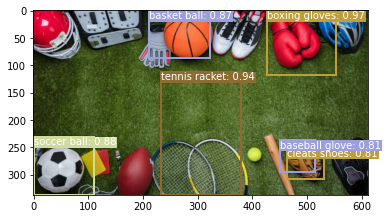

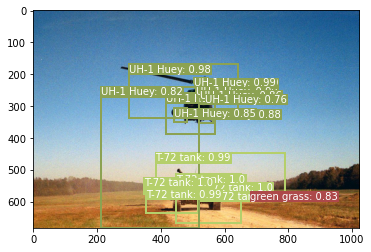

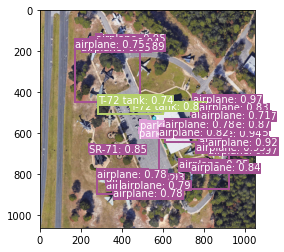

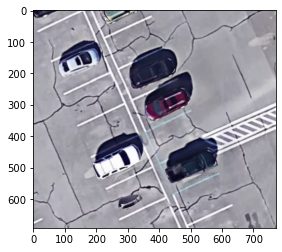

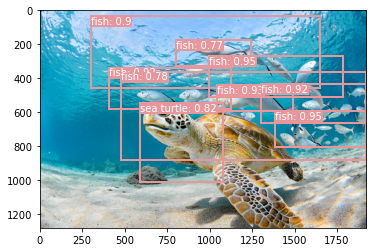

In [4]:
from evaluation import eval
#args:
#     rpn_score_thresh = minimum threshold objectness score. default: 0.05
#     iou_thresh = minimum overlap to be considered the same object. default: 0.2
#     conf_thresh = minimum classification confidence. default: 0.9
#     item_list = list of classes
#     WEIGHTS_NAME = the subname of thw weights file
#     MODEL_EPOCH = epoch of trained model
eval(item_list, iou_thresh=.2, conf_thresh=.7, MODEL_TYPE = 'CLIP-RPN', WEIGHTS_NAME='rpn', image_dir=image_dir)